In [25]:
library(circlize)
library(ComplexHeatmap)
library(data.table)

In [26]:
trans_dir = "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/from_wei/trans_Plasma_tophits_multianno/"
trans_files = paste0(trans_dir,list.files(trans_dir))
head(trans_files,2)

[1] "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/from_wei/trans_Plasma_tophits_multianno/A1BG_Plasma_count_gw_allchr.txt_result.tophits.annovar.txt.hg19_multianno.txt"
[2] "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/from_wei/trans_Plasma_tophits_multianno/AAAS_Plasma_count_gw_allchr.txt_result.tophits.annovar.txt.hg19_multianno.txt"

In [27]:
# # Manual pruning of "independent" SNPs based on distance

# dist = 500000
# for (myfile in trans_files){
#     df = fread(myfile)
#     df = unique(df)
#     df_list = list()
#     to_include_snps = c()
#     for (chrom in unique(df$Chr)){
#         snps = df[df$Chr==chrom,"Start"]$Start
#         if (length(snps)==1){chrom_snps = snps}
#         else {
#             chrom_snps = snps[1]
#             for (i in 2:length(snps)){
#                 snp = snps[i]
#                 mydist = snp-chrom_snps[length(chrom_snps)]
#                 if (mydist>dist){chrom_snps = c(chrom_snps, snp)}
#             }
#         }
#         to_include_snps = c(to_include_snps,chrom_snps)
#         df_list[[chrom]] = df[df$Chr==chrom & df$Start %in% to_include_snps, ]
#     }
#     df_new = rbindlist(df_list)
#     out_file = paste0(myfile,".merged.txt")
#     fwrite(df_new, out_file)
# }

In [28]:
gene_locs_file = "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/GeneLocations.tsv"
gene_loc = fread(gene_locs_file)
head(gene_loc)

gene_name,gene_id,seqid,start,end,strand
<chr>,<chr>,<chr>,<int>,<int>,<chr>
AL627309.1,ENSG00000237683,1,134901,139379,-
AL669831.1,ENSG00000269831,1,738532,739137,-
AL645608.2,ENSG00000269308,1,818043,819983,+
AL645608.1,ENSG00000268179,1,861264,866445,-
AL645728.1,ENSG00000215014,1,1510355,1511373,+
AL590822.2,ENSG00000269554,1,2121237,2123179,+


In [29]:
gene_files = list.files(paste0(trans_dir,"merged/"), pattern=".merged.txt")
length(gene_files)
head(gene_files,2)

[1] 5484

[1] "A1BG_Plasma_count_gw_allchr.txt_result.tophits.annovar.txt.hg19_multianno.txt.merged.txt"
[2] "AAAS_Plasma_count_gw_allchr.txt_result.tophits.annovar.txt.hg19_multianno.txt.merged.txt"

In [30]:
genes = gsub("_Plasma_count_gw_allchr.txt_result.tophits.annovar.txt.hg19_multianno.txt.merged.txt", "", gene_files)
length(genes)
head(genes)

[1] 5484

[1] "A1BG"  "AAAS"  "AAGAB" "AAK1"  "AAMDC" "AAR2"

In [31]:
df_list = list()
for (i in 1:length(genes)){
    gene = genes[i]
    chrom = gene_loc[gene_loc$gene_name == gene,"seqid"]$seqid[1]
    gene_start = gene_loc[gene_loc$gene_name == gene,"start"]$start[1]
    gene_end = gene_loc[gene_loc$gene_name == gene,"end"]$end[1]
    file = paste0(trans_dir,"merged/",gene_files[i])
    df = as.data.frame(fread(file))
    if (nrow(df)==0){next}
    colnames(df)[(ncol(df)-2):ncol(df)] <- c("p.value","neg.log10.p.value","cis.trans")
    if (nrow(df)==0){next}
    # remove HLA region (https://www.ncbi.nlm.nih.gov/grc/human/regions/MHC?asm=GRCh37)
    df = df[!(df$Chr==6 & df$Start >= 28477797 & df$Start <= 33448354),]
    if (nrow(df)==0){next}
    colnames(df)[1:5] <- paste0("snp_",colnames(df)[1:5])
    df$gene_chr = chrom
    df$gene_start = gene_start
    df$gene_end = gene_end
    df$window_start = max(0,min(gene_start, gene_end)-2000000)
    df$window_end = max(gene_start, gene_end)+2000000
    df$gene = gene
    df_list[[gene]] = df
}
df_combine = rbindlist(df_list)

In [32]:
nrow(df_combine)
head(df_combine)

[1] 16026

snp_Chr,snp_Start,snp_End,snp_Ref,snp_Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene,⋯,SiPhy_29way_logOdds,p.value,neg.log10.p.value,cis.trans,gene_chr,gene_start,gene_end,window_start,window_end,gene
<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<chr>
2,81711544,81711544,A,C,intergenic,LINC01815;DHFRP3,dist=17474;dist=1372383,NA,NA,⋯,NA,3.46904e-06,5.459791,potential_novel,19,58856544,58864865,56856544,60864865,A1BG
2,123395522,123395522,G,T,intergenic,TSN;LINC01826,dist=870094;dist=428210,NA,NA,⋯,NA,2.81880e-06,5.549936,potential_novel,19,58856544,58864865,56856544,60864865,A1BG
13,35550542,35550542,A,C,intronic,NBEA,,NA,NA,⋯,NA,2.16392e-06,5.664759,potential_novel,19,58856544,58864865,56856544,60864865,A1BG
21,36357861,36357861,A,G,intronic,RUNX1,,NA,NA,⋯,NA,3.12506e-06,5.505142,potential_novel,19,58856544,58864865,56856544,60864865,A1BG
7,157788688,157788688,A,G,intronic,PTPRN2,NA,NA,NA,⋯,NA,4.53695e-06,5.343236,potential_novel,12,53701240,53718648,51701240,55718648,AAAS
22,17632744,17632744,A,T,intronic,HDHD5,NA,NA,NA,⋯,NA,4.99518e-06,5.301449,potential_novel,12,53701240,53718648,51701240,55718648,AAAS


In [33]:
# create a matrix, SNP chromosome by gene chromosome
mat=as.matrix(table(df_combine$snp_Chr, df_combine$gene_chr))
# add "chr" to chromosome names
rownames(mat) = paste0("chr",rownames(mat))
colnames(mat) = paste0("chr",colnames(mat))
# sort chromosomes from 1 to 22
mat = mat[paste0("chr",1:22),paste0("chr",1:22)]

In [34]:
max(mat)

[1] 196

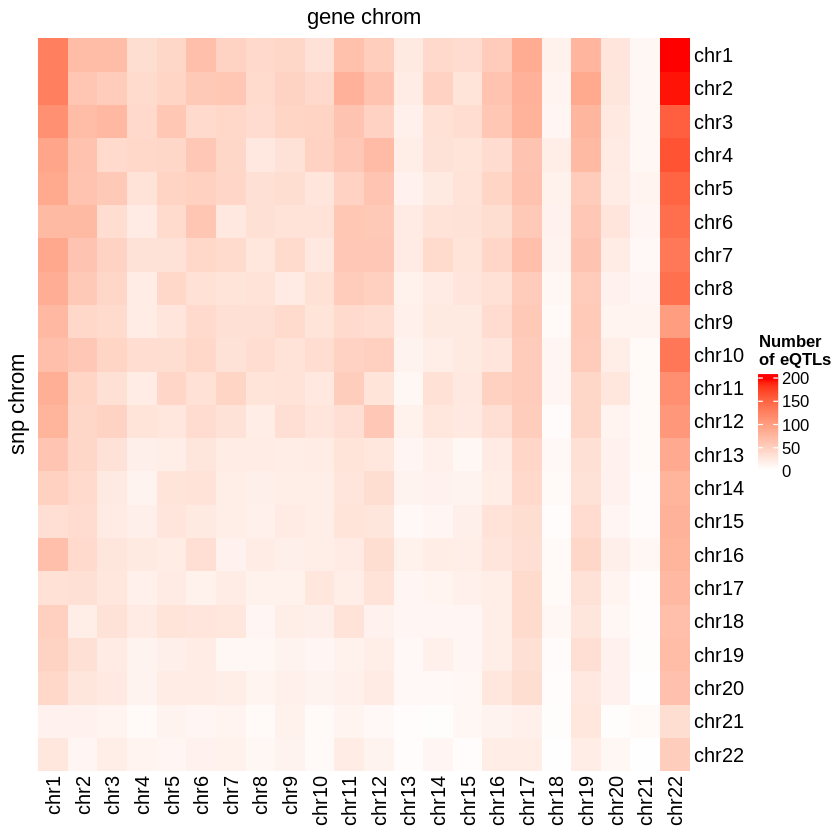

In [35]:
# all results (cis + trans)
col_fun = colorRamp2(c(0, max(mat)), c("white", "red"))
Heatmap(mat, cluster_rows = FALSE, cluster_columns = FALSE, name = "Number \nof eQTLs", 
        row_title = "snp chrom", column_title = "gene chrom", col=col_fun)

In [36]:
fig_dir <- "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/ms_figures/trans/"
pdf(paste0(fig_dir,"Plasma_trans_cis_heatmap.pdf"), width=10, height=10)
Heatmap(mat, cluster_rows = FALSE, cluster_columns = FALSE, name = "Number \nof eQTLs", 
        row_title = "snp chrom", column_title = "gene chrom", col=col_fun)
dev.off()

png 
  2

In [37]:
# trans only (different chromosome and or not within 2Mb of gene)
# df_combine_trans_only = df_combine[df_combine$cis.trans == "potential_novel"]
df_combine$cis.trans.2mb = "trans"
df_combine$snp_Chr = as.character(df_combine$snp_Chr)
df_combine[df_combine$gene_chr == df_combine$snp_Chr & df_combine$snp_Start >= df_combine$window_start & df_combine$snp_Start <= df_combine$window_end, "cis.trans.2mb"] = "cis"
table(df_combine$cis.trans.2mb)
df_combine_trans_only = df_combine[df_combine$cis.trans.2mb == "trans"]


  cis trans 
  134 15892 

In [38]:
# table(df_combine_trans_only[df_combine_trans_only$gene_chr == '22','gene'])

In [39]:
mat_trans=as.matrix(table(df_combine_trans_only$snp_Chr, df_combine_trans_only$gene_chr))
rownames(mat_trans) = paste0("chr",rownames(mat_trans))
colnames(mat_trans) = paste0("chr",colnames(mat_trans))
mat_trans = mat_trans[paste0("chr",1:22),paste0("chr",1:22)]

In [40]:
max(mat_trans)

[1] 196

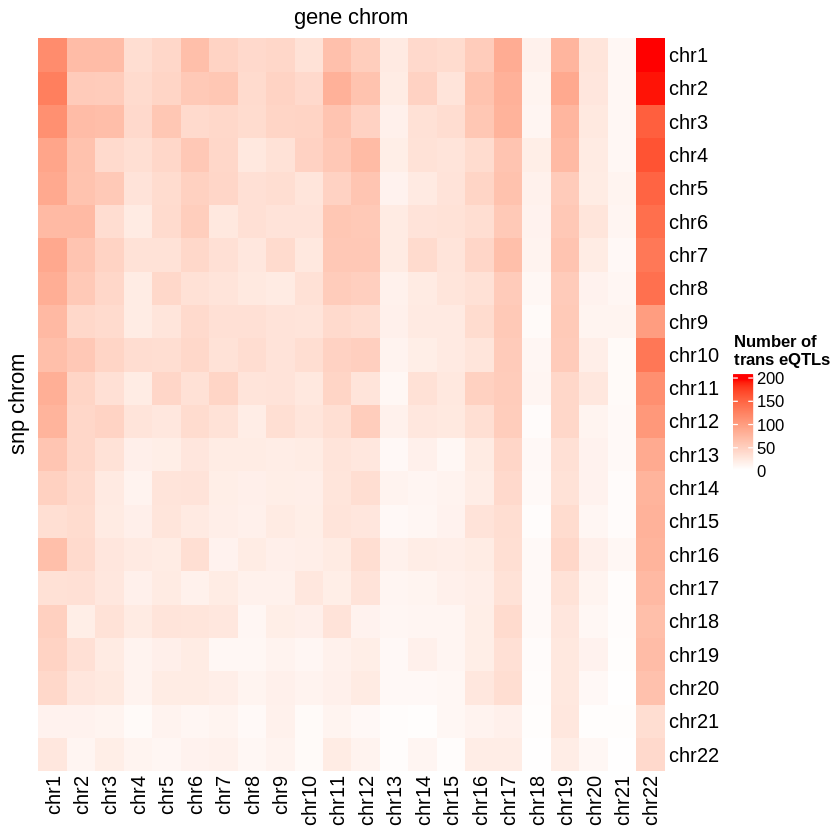

In [41]:
col_fun = colorRamp2(c(0, max(mat_trans)), c("white", "red"))
Heatmap(mat_trans, cluster_rows = FALSE, cluster_columns = FALSE, name = "Number of \ntrans eQTLs", 
        row_title = "snp chrom", column_title = "gene chrom", col=col_fun)

In [42]:
fig_dir <- "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/ms_figures/trans/"
pdf(paste0(fig_dir,"Plasma_trans_only_heatmap.pdf"), width=10, height=10)
Heatmap(mat_trans, cluster_rows = FALSE, cluster_columns = FALSE, name = "Number of \ntrans eQTLs", 
        row_title = "snp chrom", column_title = "gene chrom", col=col_fun)
dev.off()

png 
  2